<a href="https://colab.research.google.com/github/BojanKomazec/tensorflow-demo-notebooks/blob/main/multiclass_classification_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from keras import layers

In [2]:
#
# Load data
#

# The original dataset and dataset description:
# https://archive.ics.uci.edu/ml/datasets/Iris
#
# This csv file only uses different (shorter) label names and also contains 
# column names (headers).
#
url_dataset = 'https://raw.githubusercontent.com/BojanKomazec/tensorflow-demo-notebooks/main/data/iris.csv'
df_dataset = pd.read_csv(url_dataset)

In [3]:
#
# Exploratory Analasys
#

#
# Show dataframe with dataset in order to identify features and labels.
#
# By looking the columns we can identify:
# - Input features (predictors): sepal_length, sepal_width, petal_length, petal_width
# - Output labels (responses): species
display(df_dataset)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [4]:
#
# Exploratory Analasys
#

# Let's check if dataset is balanced in terms of labels (do we have similar 
# number of examples for each class)
df_dataset['species'].value_counts()

versicolor    50
virginica     50
setosa        50
Name: species, dtype: int64

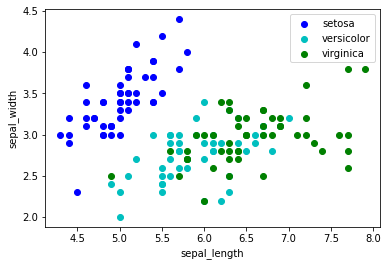

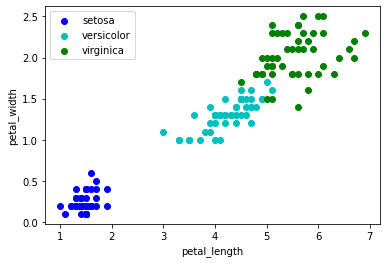

In [5]:
#
# Exploratory Analasys
#

df_setosa = df_dataset.loc[df_dataset['species'] == 'setosa']
df_versicolor = df_dataset.loc[df_dataset['species'] == 'versicolor']
df_virginica = df_dataset.loc[df_dataset['species'] == 'virginica']

def plot_features(length, width):
  setosa = plt.scatter(df_setosa[length], df_setosa[width], c='b')
  versicolor = plt.scatter(df_versicolor[length], df_versicolor[width], c='c')
  virginica = plt.scatter(df_virginica[length], df_virginica[width], c='g')
  plt.xlabel(length)
  plt.ylabel(width)
  plt.legend([setosa, versicolor, virginica], ['setosa', 'versicolor', 'virginica'])
  plt.show()

plot_features('sepal_length', 'sepal_width')
plot_features('petal_length', 'petal_width')

# From these two diagrams we can get some data insights on how features 
# determine the class:
#
# Setosas have the smallest petal length and petal width.
# Versicolors have the average petal length and petal width.
# Virginicas have the largest petal length and petal width.

In [6]:
#
# Preparing the training set (labels)
#

# Labels in our training set are strings. In a training phase they will be used
# for error estimation (loss function calculation) and so they will be compared
# to actual network outputs which are numbers. Therefore they need to be 
# converted to numbers as well. So the next step is to perform string to number 
# mapping.
#
# We have 3 label strings: 'setosa', 'versicolor', 'virginica'
# They can be mapped into numbers in multiple ways.
# Numbers we want to use should be binary for the sigmoid output of nodes in the 
# last layer of the network. 
#
# So we can perform minimal binary encoding:
#
# 'setosa' -> 00 (both neurons are zeros)
# 'versicolor' -> 01 (first neuron is 0, second is 1)
# 'virginica' -> 10 (first neuron is 1, second is 0)
#
# In this case we need to have 2 output neurons.
#
# Another option is called "One hot encoding" for the number of neurons in the
# output layer matches the number of classes and for each input only one neuron
# would fire (will have value 1, will be "hot"; this term comes from 
# electronics) and the other will be zeros.
#
# So "One hot encoding" can look like:
#
# 'setosa' -> 100 (1st neuron is 1, others are 0s)
# 'versicolor' -> 010 (2nd neuron is 1, others are 0s)
# 'virginica' -> 001 (3rd neuron is 1, others are 0s)

categories = df_dataset['species'].unique()
categories.sort()
#print(type(categories))
#print(categories)
#print(type(df_dataset['species']))

# List Comprehension
f = lambda species: np.argwhere(categories == species)[0][0]
# Numeric encoding: output is a list of categories values in numeric form
categories_numeric = [f(species) for species in df_dataset['species']]

#
# one hot encoding
#

# 1st option: keras.utils.to_categorical()
categories_ohe = keras.utils.to_categorical(categories_numeric)
#print(categories_ohe)

# 2nd option: tf.one_hot()
inputs = tf.one_hot(categories_numeric, len(categories))
#print(inputs.numpy())

# 3rd option: pandas.get_dummies()
df_dataset = df_dataset.join(pd.get_dummies(df_dataset.species))
df_dataset

,sepal_length,sepal_width,petal_length,petal_width,species,setosa,versicolor,virginica
0,5.1,3.5,1.4,0.2,setosa,1,0,0
1,4.9,3.0,1.4,0.2,setosa,1,0,0
2,4.7,3.2,1.3,0.2,setosa,1,0,0
3,4.6,3.1,1.5,0.2,setosa,1,0,0
4,5.0,3.6,1.4,0.2,setosa,1,0,0
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,0,0,1
146,6.3,2.5,5.0,1.9,virginica,0,0,1
147,6.5,3.0,5.2,2.0,virginica,0,0,1
148,6.2,3.4,5.4,2.3,virginica,0,0,1


In [7]:
#
# shuffle dataframe in-place and reset the index
# drop=True prevents .reset_index from creating a column containing the old
# index entries
#
df_dataset = df_dataset.sample(frac=1).reset_index(drop=True)
df_dataset

,sepal_length,sepal_width,petal_length,petal_width,species,setosa,versicolor,virginica
0,6.6,2.9,4.6,1.3,versicolor,0,1,0
1,5.1,3.7,1.5,0.4,setosa,1,0,0
2,5.7,2.6,3.5,1.0,versicolor,0,1,0
3,5.0,3.6,1.4,0.2,setosa,1,0,0
4,6.7,3.1,5.6,2.4,virginica,0,0,1
...,...,...,...,...,...,...,...,...
145,6.3,3.4,5.6,2.4,virginica,0,0,1
146,6.4,3.2,5.3,2.3,virginica,0,0,1
147,5.8,2.7,3.9,1.2,versicolor,0,1,0
148,6.5,2.8,4.6,1.5,versicolor,0,1,0


In [8]:
  dataset_train = df_dataset.sample(frac=0.8, random_state=0)
  print(f'dataset_train.shape = {dataset_train.shape}')
  dataset_test = df_dataset.drop(dataset_train.index)
  print(f'dataset_test.shape = {dataset_test.shape}')

dataset_train.shape = (120, 8)
dataset_test.shape = (30, 8)


In [9]:
# Extract dataset with training features and labels
datasest_train_features = dataset_train.iloc[:, 0:-4]
dataset_train_labels = dataset_train.iloc[:, -3:]

print(datasest_train_features.head())
print(dataset_train_labels.head())
print(datasest_train_features.shape)
print(dataset_train_labels.shape)

datasest_test_features = dataset_test.iloc[:, 0:-4]
dataset_test_labels = dataset_test.iloc[:, -3:]

print(datasest_test_features.head())
print(dataset_test_labels.head())
print(datasest_test_features.shape)
print(dataset_test_labels.shape)

     sepal_length  sepal_width  petal_length  petal_width
114           5.1          3.5           1.4          0.3
62            5.4          3.7           1.5          0.2
33            6.7          3.1           4.7          1.5
107           5.2          3.4           1.4          0.2
7             6.0          2.9           4.5          1.5
     setosa  versicolor  virginica
114       1           0          0
62        1           0          0
33        0           1          0
107       1           0          0
7         0           1          0
(120, 4)
(120, 3)
    sepal_length  sepal_width  petal_length  petal_width
9            4.9          3.1           1.5          0.1
14           6.3          2.5           5.0          1.9
19           4.3          3.0           1.1          0.1
21           5.4          3.4           1.5          0.4
25           6.2          3.4           5.4          2.3
    setosa  versicolor  virginica
9        1           0          0
14       0    

In [18]:
#
# Build a model with 3 neurons
#

FEATURES_COUNT = datasest_train_features.shape[1]
print(f'FEATURES_COUNT = {FEATURES_COUNT}')

HIDDEN_LAYER_UNITS_NUMBER = 0
OUTPUT_LAYER_UNITS_NUMBER = dataset_train_labels.shape[1]
ACTIVATION = tf.keras.activations.softmax

model = tf.keras.Sequential([
    layers.Dense(input_shape=(FEATURES_COUNT,),
                 units=OUTPUT_LAYER_UNITS_NUMBER,
                 activation=ACTIVATION
    )
])


model.build(datasest_train_features.shape)
model.summary()

FEATURES_COUNT = 4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_2 (ModuleWrap (120, 3)                  15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [19]:
# The binary_crossentropy binary cross entropy used in the previous Logistic 
# regression for two classifications, where categorical_crossentropy is used for 
# multi-classification

LOSS = tf.keras.losses.CategoricalCrossentropy()

# Note that the target data must be one-hot encoded, only use this to calculate 
# the softmax cross entropy
#
# From Keras documentation:
# tf.keras.losses.CategoricalCrossentropy - Use this crossentropy loss function 
# when there are two or more label classes. We expect labels to be provided in a
# one_hot representation. If you want to provide labels as integers, please use 
# SparseCategoricalCrossentropy loss. 
#
model.compile(optimizer='adam', loss=LOSS,  metrics=['acc'])

In [20]:
EPOCHS = 500
history = model.fit(
    datasest_train_features,
    dataset_train_labels,
    epochs=EPOCHS,
    verbose=0)

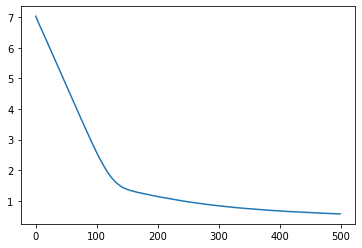

In [21]:
plt.plot(range(EPOCHS),history.history.get('loss'))

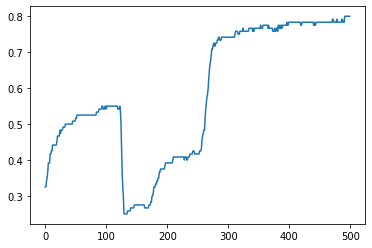

In [23]:
plt.plot(range(EPOCHS),history.history.get('acc'))

In [24]:
predictions = model.predict(datasest_test_features)
print(predictions.shape)
print(predictions[0])
print(type(predictions[0]))

# 
# Let's verify that the sum of predictions for each test example is 1:
#
print(np.sum(predictions[0]))
print(np.sum(predictions[1]))
print(np.sum(predictions[29]))

print(predictions)

(30, 3)
[0.692372   0.19453493 0.11309302]
<class 'numpy.ndarray'>
1.0
1.0
1.0
[[0.692372   0.19453493 0.11309302]
 [0.05082449 0.43778956 0.511386  ]
 [0.7503472  0.13256027 0.11709249]
 [0.72956395 0.1489665  0.12146954]
 [0.07145709 0.15180777 0.7767352 ]
 [0.05097154 0.34827173 0.60075676]
 [0.17766131 0.45070606 0.37163267]
 [0.11155351 0.4526263  0.4358202 ]
 [0.08069261 0.6968008  0.22250657]
 [0.692372   0.19453493 0.11309302]
 [0.8826666  0.05367194 0.06366141]
 [0.7477642  0.14777417 0.10446161]
 [0.0437756  0.28955892 0.66666543]
 [0.187533   0.3343174  0.47814962]
 [0.75951326 0.11341329 0.12707342]
 [0.04342125 0.33980522 0.61677355]
 [0.1821087  0.38470364 0.4331876 ]
 [0.6777281  0.18083653 0.14143538]
 [0.15474722 0.38539213 0.45986062]
 [0.0627133  0.35316232 0.5841244 ]
 [0.8862755  0.04318415 0.07054028]
 [0.1596013  0.30485472 0.5355439 ]
 [0.08598708 0.45573333 0.45827958]
 [0.7522515  0.14048086 0.10726766]
 [0.02425907 0.55113685 0.42460406]
 [0.04033684 0.148087